## Simple Test

In [1]:

import networkx as nx

# 创建一个无向图
G = nx.Graph()

# 添加节点，每个节点代表一个房间或区域
# 节点可以包含额外的信息，比如房间类型
G.add_node('客厅', type='living_room')
G.add_node('厨房', type='kitchen')
G.add_node('卧室', type='bedroom')

# 添加边，表示这些区域之间的连接关系
G.add_edge('客厅', '厨房', door_type='sliding_door')
G.add_edge('客厅', '卧室', door_type='swing_door')

In [2]:
# 计算从客厅到卧室的最短路径
shortest_path = nx.shortest_path(G, source='客厅', target='卧室')
print("从客厅到卧室的最短路径:", shortest_path)

从客厅到卧室的最短路径: ['客厅', '卧室']


In [3]:
# 计算从客厅到卧室的最短路径
shortest_path = nx.shortest_path(G, source='厨房', target='卧室')
print("从客厅到卧室的最短路径:", shortest_path)

从客厅到卧室的最短路径: ['厨房', '客厅', '卧室']


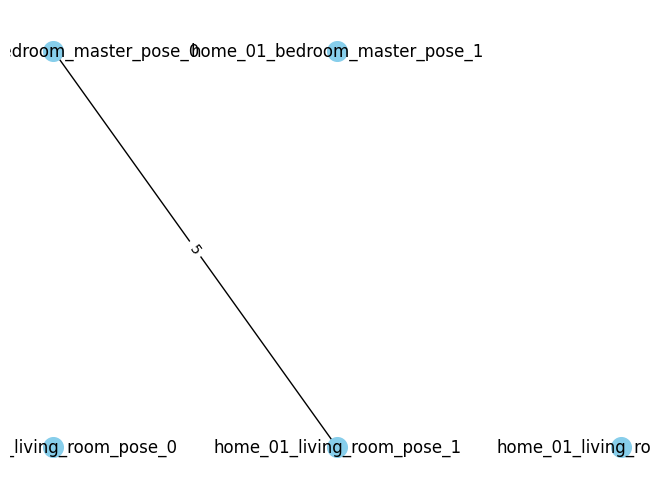

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

class HomeTopologyGraph:
    def __init__(self):
        self.G = nx.Graph()

    def add_room(self, scene_id, room_id, area_class, sub_locations):
        """
        添加房间到拓扑图中。
        
        :param scene_id: 房间场景编号
        :param room_id: 房间唯一ID
        :param area_class: 区域类别（客厅、卧室等）
        :param sub_locations: 该房间内的不同位置列表，每个位置包含其世界坐标和其他属性
        """
        for i, loc in enumerate(sub_locations):
            node_id = f"{scene_id}_{room_id}_pose_{i}"
            self.G.add_node(
                node_id,
                scene_id=scene_id,
                room_id=room_id,
                area_class=area_class,
                sub_location_id=i,
                position=loc['position'],
                orientation=loc.get('orientation', 0.0),
                is_navigable=loc.get('is_navigable', True)
            )

    def connect_rooms(self, pose_a, pose_b, distance, **kwargs):
        """
        连接两个位置点。
        
        :param pose_a: 第一个位置点ID
        :param pose_b: 第二个位置点ID
        :param distance: 两点之间的距离
        """
        self.G.add_edge(pose_a, pose_b, distance=distance, **kwargs)

    def visualize(self):
        """
        可视化拓扑图。
        """
        pos = {node: attr['position'][:2] for node, attr in self.G.nodes(data=True)}
        nx.draw(self.G, pos, with_labels=True, node_size=200, node_color='skyblue')
        labels = nx.get_edge_attributes(self.G, 'distance')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)
        plt.show()

# 示例使用
if __name__ == "__main__":
    home_graph = HomeTopologyGraph()
    
    # 假设场景编号为 "home_01"
    scene_id = "home_01"

    # 客厅有3个导航点
    living_room_sub_locs = [
        {"position": (0, 0, 0), "orientation": 0},
        {"position": (3, 0, 0), "orientation": 0},
        {"position": (6, 0, 0), "orientation": 0}
    ]
    home_graph.add_room(scene_id, "living_room", "客厅", living_room_sub_locs)

    # 主卧室有两个导航点
    bedroom_master_sub_locs = [
        {"position": (0, 5, 0)},
        {"position": (3, 5, 0)}
    ]
    home_graph.add_room(scene_id, "bedroom_master", "主卧", bedroom_master_sub_locs)

    # 连接客厅与主卧室的一个导航点
    home_graph.connect_rooms("home_01_living_room_pose_1", "home_01_bedroom_master_pose_0", distance=5)

    # 可视化
    home_graph.visualize()

## Define class and visulize use matplotlib

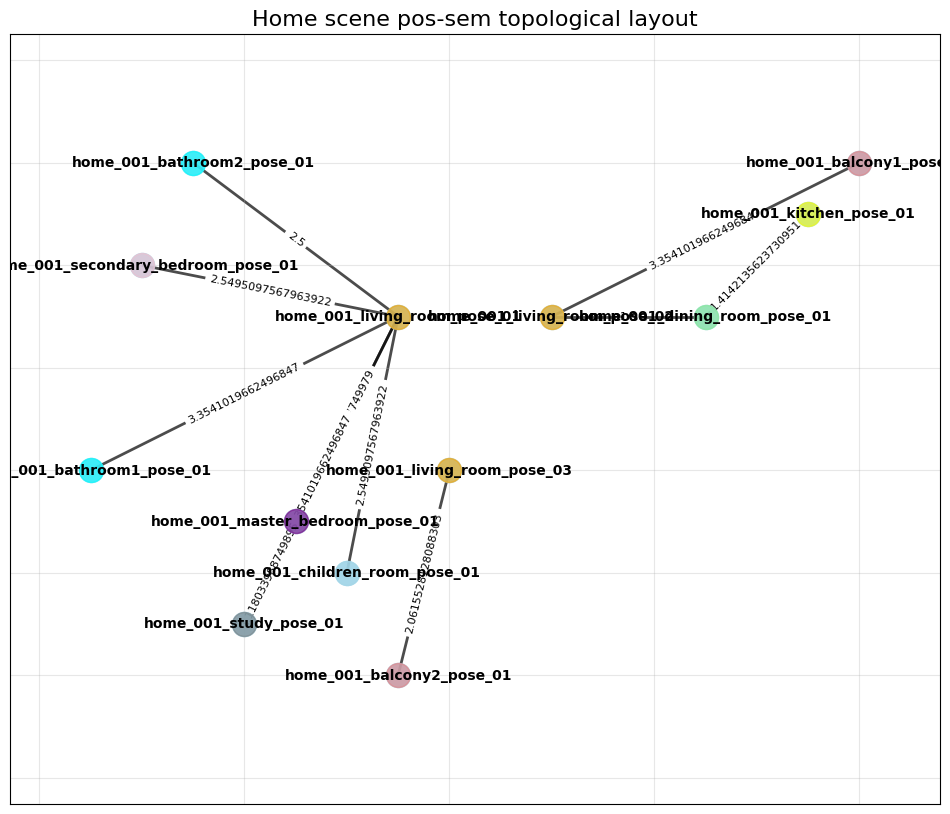

Path from living room to kitchen: ['home_001_living_room_pose_02', 'home_001_dining_room_pose_01', 'home_001_kitchen_pose_01']


In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

class HomeTopologyGraph:
    def __init__(self, scene_id="home_001"):
        self.scene_id = scene_id
        self.G = nx.Graph()
        self.node_positions = {}  # 存储每个节点的 (x, y) 坐标用于绘图

    def add_pose(self, node_id, area_class, room_id, position, orientation=0.0, is_navigable=True, viewed_objects=None):
        """
        添加一个导航点（pose）到图中。
        
        :param node_id: 唯一节点ID（如 "home_001_living_room_pose_01"）
        :param area_class: 区域类别（客厅、厨房等）
        :param room_id: 房间唯一ID
        :param position: (x, y, z) 或 (x, y)
        :param orientation: 朝向（弧度）
        :param is_navigable: 是否可通行
        :param viewed_objects: 可见物品列表（字典）
        """
        # 正确解析 sub_location_id
        sub_location_id = node_id.split('_')[-1] if '_' in node_id else None
        
        self.G.add_node(
            node_id,
            scene_id=self.scene_id,
            area_class=area_class,
            room_id=room_id,
            sub_location_id=sub_location_id,  # 更新为正确的获取方式
            position=np.array(position),
            orientation=orientation,
            is_navigable=is_navigable,
            viewed_objects=viewed_objects or []
        )
        self.node_positions[node_id] = position[:2]  # 仅保存 x, y 用于绘图

    def connect(self, node_a, node_b, distance=None, door_type=None):
        """连接两个节点"""
        if distance is None:
            pos_a = self.node_positions[node_a]
            pos_b = self.node_positions[node_b]
            distance = np.linalg.norm(np.array(pos_a) - np.array(pos_b))
        self.G.add_edge(node_a, node_b, distance=distance, door_type=door_type)

    def visualize(self, figsize=(12, 10), show_labels=True):
        """使用真实世界坐标进行可视化，反映空间关系"""
        plt.figure(figsize=figsize)
        pos = self.node_positions  # 使用真实坐标作为布局

        # 绘制节点
        nx.draw_networkx_nodes(self.G, pos, node_size=300, node_color='skyblue', alpha=0.8)
        nx.draw_networkx_edges(self.G, pos, width=2, alpha=0.7)
        nx.draw_networkx_labels(self.G, pos, font_size=10, font_weight='bold')

        # 绘制边上的距离标签
        edge_labels = nx.get_edge_attributes(self.G, 'distance')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels, font_size=8)

        # 添加房间类别的颜色标记（可选）
        colors = {
            '客厅': 'orange',
            '餐厅': 'lightgreen',
            '厨房': 'yellow',
            '主卧': 'purple',
            '次卧': 'pink',
            '儿童房': 'lightblue',
            '书房': 'gray',
            '卫生间': 'cyan',
            '阳台': 'lightcoral'
        }
        for node, attr in self.G.nodes(data=True):
            area = attr['area_class']
            if area in colors:
                nx.draw_networkx_nodes(self.G, pos, nodelist=[node], node_color=colors[area], node_size=300, alpha=0.6)

        plt.axis('equal')  # 保持比例
        plt.title("Home scene pos-sem topological layout", fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.show()

    def get_path(self, start, end):
        """计算最短路径"""
        try:
            path = nx.shortest_path(self.G, source=start, target=end, weight='distance')
            return path
        except nx.NetworkXNoPath:
            print(f"from {start} to {end} no path")
            return None

# ========================
# 定义房间和导航点（基于户型图）
# ========================

def create_home_graph():
    home = HomeTopologyGraph(scene_id="home_001")

    # ------------------------------
    # 客厅 (Living Room)
    # ------------------------------
    living_poses = [
        ("pose_01", (3.5, 3.5), 0.0, ["沙发", "电视", "茶几"]),
        ("pose_02", (5.0, 3.5), 0.0, ["电视柜", "地毯"]),
        ("pose_03", (4.0, 2.0), 0.0, ["落地灯", "植物"]),
    ]
    for name, pos, ori, objs in living_poses:
        node_id = f"{home.scene_id}_living_room_{name}"
        home.add_pose(node_id, "客厅", "living_room", pos, ori, True, objs)

    # ------------------------------
    # 餐厅 (Dining Room)
    # ------------------------------
    dining_poses = [
        ("pose_01", (6.5, 3.5), 0.0, ["餐桌", "椅子"]),
    ]
    for name, pos, ori, objs in dining_poses:
        node_id = f"{home.scene_id}_dining_room_{name}"
        home.add_pose(node_id, "餐厅", "dining_room", pos, ori, True, objs)

    # ------------------------------
    # 厨房 (Kitchen)
    # ------------------------------
    kitchen_poses = [
        ("pose_01", (7.5, 4.5), 0.0, ["灶台", "冰箱", "水槽"]),
    ]
    for name, pos, ori, objs in kitchen_poses:
        node_id = f"{home.scene_id}_kitchen_{name}"
        home.add_pose(node_id, "厨房", "kitchen", pos, ori, True, objs)

    # ------------------------------
    # 主卧 (Master Bedroom)
    # ------------------------------
    master_bedroom_poses = [
        ("pose_01", (2.5, 1.5), 0.0, ["床", "衣柜", "床头柜"]),
    ]
    for name, pos, ori, objs in master_bedroom_poses:
        node_id = f"{home.scene_id}_master_bedroom_{name}"
        home.add_pose(node_id, "主卧", "master_bedroom", pos, ori, True, objs)

    # ------------------------------
    # 次卧 (Secondary Bedroom)
    # ------------------------------
    secondary_bedroom_poses = [
        ("pose_01", (1.0, 4.0), 0.0, ["床", "书桌"]),
    ]
    for name, pos, ori, objs in secondary_bedroom_poses:
        node_id = f"{home.scene_id}_secondary_bedroom_{name}"
        home.add_pose(node_id, "次卧", "secondary_bedroom", pos, ori, True, objs)

    # ------------------------------
    # 儿童房 (Children's Room)
    # ------------------------------
    children_room_poses = [
        ("pose_01", (3.0, 1.0), 0.0, ["小床", "玩具架"]),
    ]
    for name, pos, ori, objs in children_room_poses:
        node_id = f"{home.scene_id}_children_room_{name}"
        home.add_pose(node_id, "儿童房", "children_room", pos, ori, True, objs)

    # ------------------------------
    # 书房 (Study)
    # ------------------------------
    study_poses = [
        ("pose_01", (2.0, 0.5), 0.0, ["书桌", "书架", "椅子"]),
    ]
    for name, pos, ori, objs in study_poses:
        node_id = f"{home.scene_id}_study_{name}"
        home.add_pose(node_id, "书房", "study", pos, ori, True, objs)

    # ------------------------------
    # 卫生间 (Bathroom)
    # ------------------------------
    bathroom1_poses = [
        ("pose_01", (0.5, 2.0), 0.0, ["马桶", "洗手池", "淋浴"])]
    for name, pos, ori, objs in bathroom1_poses:
        node_id = f"{home.scene_id}_bathroom1_{name}"
        home.add_pose(node_id, "卫生间", "bathroom1", pos, ori, True, objs)

    bathroom2_poses = [
        ("pose_01", (1.5, 5.0), 0.0, ["马桶", "洗手池"])]
    for name, pos, ori, objs in bathroom2_poses:
        node_id = f"{home.scene_id}_bathroom2_{name}"
        home.add_pose(node_id, "卫生间", "bathroom2", pos, ori, True, objs)

    # ------------------------------
    # 阳台 (Balcony)
    # ------------------------------
    balcony1_poses = [
        ("pose_01", (8.0, 5.0), 0.0, ["洗衣机", "花盆"])]
    for name, pos, ori, objs in balcony1_poses:
        node_id = f"{home.scene_id}_balcony1_{name}"
        home.add_pose(node_id, "阳台", "balcony1", pos, ori, True, objs)

    balcony2_poses = [
        ("pose_01", (3.5, 0.0), 0.0, ["休闲椅", "绿植"])]
    for name, pos, ori, objs in balcony2_poses:
        node_id = f"{home.scene_id}_balcony2_{name}"
        home.add_pose(node_id, "阳台", "balcony2", pos, ori, True, objs)

    # ------------------------------
    # 连接所有房间（根据户型图逻辑）
    # ------------------------------

    # 客厅 → 餐厅
    home.connect("home_001_living_room_pose_02", "home_001_dining_room_pose_01", door_type="open_door")

    # 餐厅 → 厨房
    home.connect("home_001_dining_room_pose_01", "home_001_kitchen_pose_01", door_type="kitchen_door")

    # 客厅 → 主卧
    home.connect("home_001_living_room_pose_01", "home_001_master_bedroom_pose_01", door_type="bedroom_door")

    # 客厅 → 次卧
    home.connect("home_001_living_room_pose_01", "home_001_secondary_bedroom_pose_01", door_type="bedroom_door")

    # 客厅 → 儿童房
    home.connect("home_001_living_room_pose_01", "home_001_children_room_pose_01", door_type="bedroom_door")

    # 客厅 → 书房
    home.connect("home_001_living_room_pose_01", "home_001_study_pose_01", door_type="study_door")

    # 客厅 → 卫生间1
    home.connect("home_001_living_room_pose_01", "home_001_bathroom1_pose_01", door_type="bathroom_door")

    # 客厅 → 卫生间2
    home.connect("home_001_living_room_pose_01", "home_001_bathroom2_pose_01", door_type="bathroom_door")

    # 客厅 → 阳台1
    home.connect("home_001_living_room_pose_02", "home_001_balcony1_pose_01", door_type="balcony_door")

    # 客厅 → 阳台2
    home.connect("home_001_living_room_pose_03", "home_001_balcony2_pose_01", door_type="balcony_door")

    # 书房 → 主卧
    home.connect("home_001_study_pose_01", "home_001_master_bedroom_pose_01", door_type="internal_door")

    return home

# ========================
# 运行示例
# ========================
if __name__ == "__main__":
    home = create_home_graph()
    home.visualize()

    # 示例：从客厅到厨房的最短路径
    start = "home_001_living_room_pose_02"
    end = "home_001_kitchen_pose_01"
    path = home.get_path(start, end)
    print("Path from living room to kitchen:", path)

## Use pyvis for visualizatioon

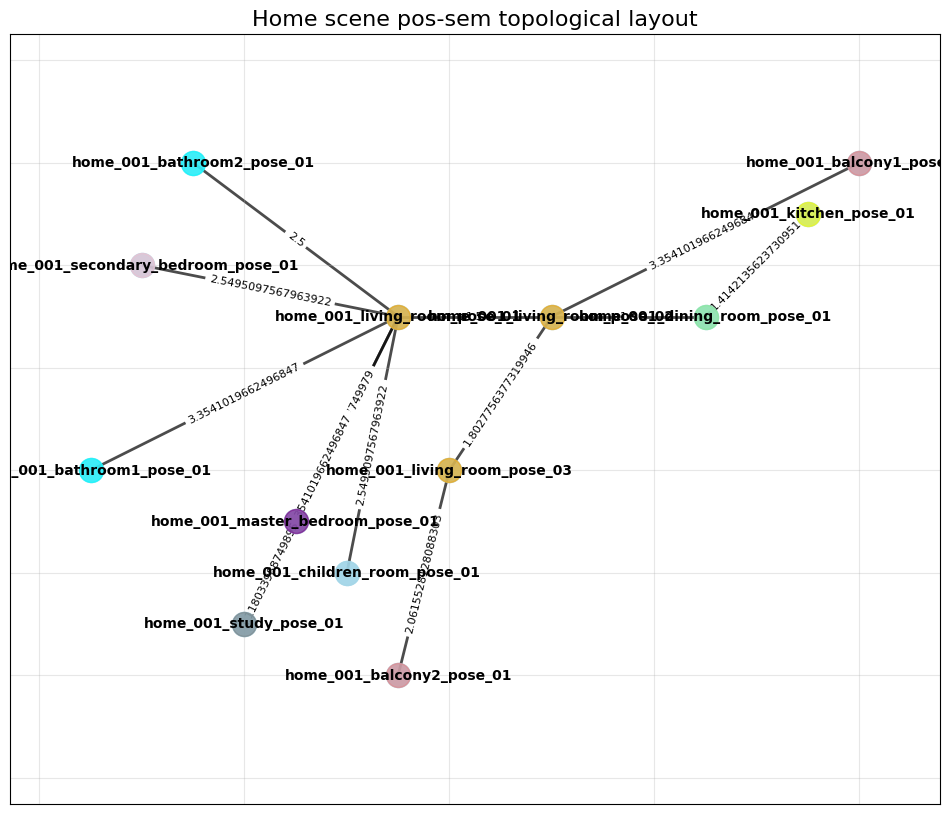

✅ Interactive graph saved to: home_topology.html
Path from living room to kitchen: ['home_001_living_room_pose_02', 'home_001_dining_room_pose_01', 'home_001_kitchen_pose_01']


In [ ]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pyvis.network import Network

class HomeTopologyGraph:
    def __init__(self, scene_id="home_001"):
        self.scene_id = scene_id
        self.G = nx.Graph()
        self.node_positions = {}  # 存储每个节点的 (x, y) 坐标用于绘图

    def add_pose(self, node_id, area_class, room_id, position, orientation=0.0, is_navigable=True, viewed_objects=None):
        """
        添加一个导航点（pose）到图中。
        
        :param node_id: 唯一节点ID（如 "home_001_living_room_pose_01"）
        :param area_class: 区域类别（客厅、厨房等）
        :param room_id: 房间唯一ID
        :param position: (x, y, z) 或 (x, y)
        :param orientation: 朝向（弧度）
        :param is_navigable: 是否可通行
        :param viewed_objects: 可见物品列表（字典）
        """
        # 正确解析 sub_location_id
        sub_location_id = node_id.split('_')[-1] if '_' in node_id else None
        
        self.G.add_node(
            node_id,
            scene_id=self.scene_id,
            area_class=area_class,
            room_id=room_id,
            sub_location_id=sub_location_id,  # 更新为正确的获取方式
            position=np.array(position),
            orientation=orientation,
            is_navigable=is_navigable,
            viewed_objects=viewed_objects or []
        )
        self.node_positions[node_id] = position[:2]  # 仅保存 x, y 用于绘图

    def connect(self, node_a, node_b, distance=None, door_type=None):
        """连接两个节点"""
        if distance is None:
            pos_a = self.node_positions[node_a]
            pos_b = self.node_positions[node_b]
            distance = np.linalg.norm(np.array(pos_a) - np.array(pos_b))
        self.G.add_edge(node_a, node_b, distance=distance, door_type=door_type)

    def visualize(self, figsize=(12, 10), show_labels=True):
        """使用真实世界坐标进行可视化，反映空间关系"""
        plt.figure(figsize=figsize)
        pos = self.node_positions  # 使用真实坐标作为布局

        # 绘制节点
        nx.draw_networkx_nodes(self.G, pos, node_size=300, node_color='skyblue', alpha=0.8)
        nx.draw_networkx_edges(self.G, pos, width=2, alpha=0.7)
        nx.draw_networkx_labels(self.G, pos, font_size=10, font_weight='bold')

        # 绘制边上的距离标签
        edge_labels = nx.get_edge_attributes(self.G, 'distance')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels, font_size=8)

        # 添加房间类别的颜色标记（可选）
        colors = {
            '客厅': 'orange',
            '餐厅': 'lightgreen',
            '厨房': 'yellow',
            '主卧': 'purple',
            '次卧': 'pink',
            '儿童房': 'lightblue',
            '书房': 'gray',
            '卫生间': 'cyan',
            '阳台': 'lightcoral'
        }
        for node, attr in self.G.nodes(data=True):
            area = attr['area_class']
            if area in colors:
                nx.draw_networkx_nodes(self.G, pos, nodelist=[node], node_color=colors[area], node_size=300, alpha=0.6)

        plt.axis('equal')  # 保持比例
        plt.title("Home scene pos-sem topological layout", fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.show()

    def visualize_html(self, filename="home_topology.html", show_buttons=False):
        """
        生成交互式 HTML 可视化图。
        - 节点显示简短标签（如 LR-01）
        - 悬停/点击显示完整属性
        """
        net = Network(
            height="800px",
            width="100%",
            bgcolor="#ffffff",
            font_color="black",
            directed=False
        )
        net.toggle_physics(True)  # 启用物理引擎自动布局（可选）
        if show_buttons:
            net.show_buttons()  # 显示控制面板（调试用）

        # 颜色映射（与 matplotlib 一致）
        color_map = {
            '客厅': '#FFA500',      # orange
            '餐厅': '#90EE90',      # lightgreen
            '厨房': '#FFFF00',      # yellow
            '主卧': '#800080',      # purple
            '次卧': '#FFC0CB',      # pink
            '儿童房': '#ADD8E6',    # lightblue
            '书房': '#808080',      # gray
            '卫生间': '#00FFFF',    # cyan
            '阳台': '#F08080'       # lightcoral
        }

        # 添加节点
        for node_id, attr in self.G.nodes(data=True):
            # 生成简洁标签，例如：
            # home_001_living_room_pose_01 → LR-01
            parts = node_id.split('_')
            room_abbr = {
                'living_room': 'LR',
                'dining_room': 'DR',
                'kitchen': 'KIT',
                'master_bedroom': 'MBR',
                'secondary_bedroom': 'SBR',
                'children_room': 'CR',
                'study': 'STU',
                'bathroom1': 'BATH1',
                'bathroom2': 'BATH2',
                'balcony1': 'BAL1',
                'balcony2': 'BAL2'
            }.get(parts[2], parts[2][:3].upper())

            pose_num = parts[-1].replace('pose_', '') if 'pose_' in parts[-1] else parts[-1]
            short_label = f"{room_abbr}-{pose_num}"

            # 构建悬停/点击时显示的详细信息（HTML 格式）
            title_html = f"""
            <b>Node ID:</b> {node_id}<br>
            <b>Area:</b> {attr['area_class']}<br>
            <b>Room ID:</b> {attr['room_id']}<br>
            <b>Position:</b> ({attr['position'][0]:.2f}, {attr['position'][1]:.2f})<br>
            <b>Orientation:</b> {attr['orientation']:.2f} rad<br>
            <b>Navigable:</b> {'Yes' if attr['is_navigable'] else 'No'}<br>
            <b>Viewed Objects:</b> {', '.join(attr['viewed_objects'])}
            """

            color = color_map.get(attr['area_class'], '#CCCCCC')

            net.add_node(
                node_id,
                label=short_label,
                title=title_html,  # 鼠标悬停时显示
                color=color,
                size=25
            )

        # 添加边
        for u, v, edge_attr in self.G.edges(data=True):
            label = f"{edge_attr.get('distance', 0):.2f}m"
            net.add_edge(u, v, title=label, width=2)

        # 保存并打开 HTML
        net.save_graph(filename)
        print(f"✅ Interactive graph saved to: {filename}")
        try:
            from IPython.display import IFrame
            return IFrame(filename, width="100%", height="800")
        except:
            import webbrowser
            import os
            webbrowser.open('file://' + os.path.realpath(filename))

    def get_path(self, start, end):
        """计算最短路径"""
        try:
            path = nx.shortest_path(self.G, source=start, target=end, weight='distance')
            return path
        except nx.NetworkXNoPath:
            print(f"from {start} to {end} no path")
            return None

# ========================
# 定义房间和导航点（基于户型图）
# ========================

def create_home_graph():
    home = HomeTopologyGraph(scene_id="home_001")

    # ------------------------------
    # 客厅 (Living Room)
    # ------------------------------
    living_poses = [
        ("pose_01", (3.5, 3.5), 0.0, ["沙发", "电视", "茶几"]),
        ("pose_02", (5.0, 3.5), 0.0, ["电视柜", "地毯"]),
        ("pose_03", (4.0, 2.0), 0.0, ["落地灯", "植物"]),
    ]
    for name, pos, ori, objs in living_poses:
        node_id = f"{home.scene_id}_living_room_{name}"
        home.add_pose(node_id, "客厅", "living_room", pos, ori, True, objs)

    # ------------------------------
    # 餐厅 (Dining Room)
    # ------------------------------
    dining_poses = [
        ("pose_01", (6.5, 3.5), 0.0, ["餐桌", "椅子"]),
    ]
    for name, pos, ori, objs in dining_poses:
        node_id = f"{home.scene_id}_dining_room_{name}"
        home.add_pose(node_id, "餐厅", "dining_room", pos, ori, True, objs)

    # ------------------------------
    # 厨房 (Kitchen)
    # ------------------------------
    kitchen_poses = [
        ("pose_01", (7.5, 4.5), 0.0, ["灶台", "冰箱", "水槽"]),
    ]
    for name, pos, ori, objs in kitchen_poses:
        node_id = f"{home.scene_id}_kitchen_{name}"
        home.add_pose(node_id, "厨房", "kitchen", pos, ori, True, objs)

    # ------------------------------
    # 主卧 (Master Bedroom)
    # ------------------------------
    master_bedroom_poses = [
        ("pose_01", (2.5, 1.5), 0.0, ["床", "衣柜", "床头柜"]),
    ]
    for name, pos, ori, objs in master_bedroom_poses:
        node_id = f"{home.scene_id}_master_bedroom_{name}"
        home.add_pose(node_id, "主卧", "master_bedroom", pos, ori, True, objs)

    # ------------------------------
    # 次卧 (Secondary Bedroom)
    # ------------------------------
    secondary_bedroom_poses = [
        ("pose_01", (1.0, 4.0), 0.0, ["床", "书桌"]),
    ]
    for name, pos, ori, objs in secondary_bedroom_poses:
        node_id = f"{home.scene_id}_secondary_bedroom_{name}"
        home.add_pose(node_id, "次卧", "secondary_bedroom", pos, ori, True, objs)

    # ------------------------------
    # 儿童房 (Children's Room)
    # ------------------------------
    children_room_poses = [
        ("pose_01", (3.0, 1.0), 0.0, ["小床", "玩具架"]),
    ]
    for name, pos, ori, objs in children_room_poses:
        node_id = f"{home.scene_id}_children_room_{name}"
        home.add_pose(node_id, "儿童房", "children_room", pos, ori, True, objs)

    # ------------------------------
    # 书房 (Study)
    # ------------------------------
    study_poses = [
        ("pose_01", (2.0, 0.5), 0.0, ["书桌", "书架", "椅子"]),
    ]
    for name, pos, ori, objs in study_poses:
        node_id = f"{home.scene_id}_study_{name}"
        home.add_pose(node_id, "书房", "study", pos, ori, True, objs)

    # ------------------------------
    # 卫生间 (Bathroom)
    # ------------------------------
    bathroom1_poses = [
        ("pose_01", (0.5, 2.0), 0.0, ["马桶", "洗手池", "淋浴"])]
    for name, pos, ori, objs in bathroom1_poses:
        node_id = f"{home.scene_id}_bathroom1_{name}"
        home.add_pose(node_id, "卫生间", "bathroom1", pos, ori, True, objs)

    bathroom2_poses = [
        ("pose_01", (1.5, 5.0), 0.0, ["马桶", "洗手池"])]
    for name, pos, ori, objs in bathroom2_poses:
        node_id = f"{home.scene_id}_bathroom2_{name}"
        home.add_pose(node_id, "卫生间", "bathroom2", pos, ori, True, objs)

    # ------------------------------
    # 阳台 (Balcony)
    # ------------------------------
    balcony1_poses = [
        ("pose_01", (8.0, 5.0), 0.0, ["洗衣机", "花盆"])]
    for name, pos, ori, objs in balcony1_poses:
        node_id = f"{home.scene_id}_balcony1_{name}"
        home.add_pose(node_id, "阳台", "balcony1", pos, ori, True, objs)

    balcony2_poses = [
        ("pose_01", (3.5, 0.0), 0.0, ["休闲椅", "绿植"])]
    for name, pos, ori, objs in balcony2_poses:
        node_id = f"{home.scene_id}_balcony2_{name}"
        home.add_pose(node_id, "阳台", "balcony2", pos, ori, True, objs)

    # ------------------------------
    # 连接所有房间（根据户型图逻辑）
    # ------------------------------

    # 客厅 → 餐厅
    home.connect("home_001_living_room_pose_02", "home_001_dining_room_pose_01", door_type="open_door")

    # 餐厅 → 厨房
    home.connect("home_001_dining_room_pose_01", "home_001_kitchen_pose_01", door_type="kitchen_door")

    # 客厅 → 主卧
    home.connect("home_001_living_room_pose_01", "home_001_master_bedroom_pose_01", door_type="bedroom_door")

    # 客厅 → 次卧
    home.connect("home_001_living_room_pose_01", "home_001_secondary_bedroom_pose_01", door_type="bedroom_door")

    # 客厅 → 儿童房
    home.connect("home_001_living_room_pose_01", "home_001_children_room_pose_01", door_type="bedroom_door")

    # 客厅 → 书房
    home.connect("home_001_living_room_pose_01", "home_001_study_pose_01", door_type="study_door")

    # 客厅 → 卫生间1
    home.connect("home_001_living_room_pose_01", "home_001_bathroom1_pose_01", door_type="bathroom_door")

    # 客厅 → 卫生间2
    home.connect("home_001_living_room_pose_01", "home_001_bathroom2_pose_01", door_type="bathroom_door")

    # 客厅 → 阳台1
    home.connect("home_001_living_room_pose_02", "home_001_balcony1_pose_01", door_type="balcony_door")

    # 客厅 → 阳台2
    home.connect("home_001_living_room_pose_03", "home_001_balcony2_pose_01", door_type="balcony_door")

    # 书房 → 主卧
    home.connect("home_001_study_pose_01", "home_001_master_bedroom_pose_01", door_type="internal_door")

    # 客厅1 → 客厅2
    home.connect("home_001_living_room_pose_01", "home_001_living_room_pose_02", door_type="balcony_door")

    # 客厅2 → 客厅3
    home.connect("home_001_living_room_pose_02", "home_001_living_room_pose_03", door_type="balcony_door")

    # 客厅1 → 客厅3
    home.connect("home_001_living_room_pose_01", "home_001_living_room_pose_03", door_type="balcony_door")

    return home

# ========================
# 运行示例
# ========================
if __name__ == "__main__":
    home = create_home_graph()
    home.visualize()
    home.visualize_html("home_topology.html")

    # 示例：从客厅到厨房的最短路径
    start = "home_001_living_room_pose_02"
    end = "home_001_kitchen_pose_01"
    path = home.get_path(start, end)
    print("Path from living room to kitchen:", path)